# DZD Projekt Analýza zpoždění odletů a příletů z letiště JFK a LGA New York
Vypracovali :   Martin Beneš – benm32@vse.cz
                Viet Anh Do – doho01@vse.cz
                Lukáš Mikšovský – mikl08@vse.cz


In [80]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# Preprocessing
začínáme už s předpřipraveným datasetem, ve kterém jsme už upravili formáty časových dat.

In [81]:
aero = pd.read_csv("df_all_time_formatted.csv")

## Odstranění features, které nemají pro naši analýzu význam
Názvy odstraněných sloupců jsou vidět v kódu

In [82]:
aero_dropped = aero.drop(["MKT_UNIQUE_CARRIER","MKT_CARRIER_AIRLINE_ID","TAIL_NUM","FL_DATE","DEP_TIME"
                          ,"ARR_TIME","CRS_DEP_TIME","DEP_DELAY","ARR_DELAY","CRS_ARR_TIME","WHEELS_OFF","WHEELS_OFF","WHEELS_ON","MKT_CARRIER","MKT_CARRIER_FL_NUM","SCH_OP_CARRIER_FL_NUM",
                          "SCH_OP_CARRIER_FL_NUM","ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","ORIGIN_CITY_MARKET_ID","DEP_TIME_formatted"
                          ,"ARR_TIME_formatted","WHEELS_OFF_formatted","WHEELS_ON_formatted"
                          ,"ORIGIN_CITY_NAME","ORIGIN_STATE_ABR","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID","DEST_CITY_MARKET_ID","CRS_DEP_TIME_formatted","CRS_ARR_TIME_formatted","FL_DATE_formatted"
                          ,"DEST_CITY_NAME","DEST_STATE_ABR","FIRST_DEP_TIME","TOTAL_ADD_GTIME","LONGEST_ADD_GTIME"], axis='columns')

# Cleaning the DEP_DATE_TIME data
Zde jsme si opět za pomoci externího nástroje připravili tabulku obsahující pouze časy ve formátu v jakém je potřebujeme k joinu datasetů a pouze je nahradili v původním dataframu. 

In [83]:
goodcolumns = pd.read_csv("dvasl.csv")
aero_dropped[['DEP_DATE_TIME', 'ARR_DATE_TIME']] = goodcolumns[['DEP_DATE_TIME', 'ARR_DATE_TIME']]

In [84]:
aero_dropped['DEP_DATE_TIME'] = pd.to_datetime(aero_dropped['DEP_DATE_TIME'])
aero_dropped['DEP_DATE_TIME_H'] = aero_dropped['DEP_DATE_TIME'].dt.floor('H')

# Preprocessing druhého datasetu obsahující METEO data

In [85]:
meteo = pd.read_csv("meteo_n.csv", delimiter=';')

In [86]:
print(meteo.columns)

Index(['station', 'valid_date', 'valid_time_new', 'valid_date_time', 'tmpf',
       'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby', 'gust',
       'skyc1', 'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4',
       'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr',
       'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct',
       'peak_wind_time', 'feel', 'metar', 'airport', 'snowdepth'],
      dtype='object')


### Drop atributů, které nepotřebujeme

In [87]:
meteo_dropped = meteo.drop(["valid_date", "valid_time_new", "metar", "airport", "ice_accretion_1hr",
                            "ice_accretion_3hr", "ice_accretion_6hr", "snowdepth",], axis="columns")

In [88]:
print(meteo_dropped.columns)

Index(['station', 'valid_date_time', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt',
       'p01i', 'alti', 'mslp', 'vsby', 'gust', 'skyc1', 'skyc2', 'skyc3',
       'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4', 'wxcodes',
       'peak_wind_gust', 'peak_wind_drct', 'peak_wind_time', 'feel'],
      dtype='object')


### Úprava formátu časového atributu valid_date_time a následné zaokrouhlení na hodiny pro JOIN 


In [89]:
meteo_dropped['valid_date_time'] = pd.to_datetime(meteo_dropped['valid_date_time'], format = "%d.%m.%Y %H:%M")
meteo_dropped['valid_date_time_H'] = meteo_dropped['valid_date_time'].dt.floor('H')

# Merging the two dataframes
Zde jsme provedli merge. Kód je rozdělen na dva joiny, protože jsme měli problém v případech kdy bylo potřeba doplnit meteorologické data k letům s destination JFK, nebo LGA. 

In [90]:
merged_data_other_dest = pd.merge(aero_dropped[aero_dropped['DEST'].isin(['JFK', 'LGA']) == False], meteo_dropped,
                                  left_on=["DEP_DATE_TIME_H", "ORIGIN"], right_on=["valid_date_time_H", "station"], how="left")

merged_data_jfk_lga_dest = pd.merge(aero_dropped[aero_dropped['DEST'].isin(['JFK', 'LGA'])], meteo_dropped,
                                    left_on=["DEP_DATE_TIME_H", "DEST"], right_on=["valid_date_time_H", "station"], how="left")

merged_data_final = pd.concat([merged_data_other_dest, merged_data_jfk_lga_dest], ignore_index=True)


## Stanice nemá data v konkrétní hodinu
V datasetu se stále nacházela data, kdy meteorologická stanice neměla data. Těch bylo konkrétně **2504** a rozhodli jsme se je odebrat a resetovat index

In [91]:
null_station_count = merged_data_final['station'].isnull().sum()
print(null_station_count)
merged_data_final = merged_data_final.dropna(subset=['station'])
merged_data_final = merged_data_final.reset_index(drop=True)


2504


### Zde jsme opět odranili některé nepotřebné atributy

In [92]:
df = merged_data_final.drop(["OP_CARRIER_FL_NUM", "DEP_TIME_BLK", "ARR_TIME_BLK", "CANCELLATION_CODE", "DUP", 
                             "DEP_DATE_TIME", "ARR_DATE_TIME", "CRS_DEP_DATE_TIME", "CRS_ARR_DATE_TIME", "WHEELS_OFF_DATE_TIME",
                             "WHEELS_ON_DATE_TIME","DEP_DATE_TIME_H","valid_date_time", "peak_wind_gust", "peak_wind_drct", "peak_wind_time"], axis= "columns")

# Exploratory data analysis
začínáme korelační maticí numerických atributů

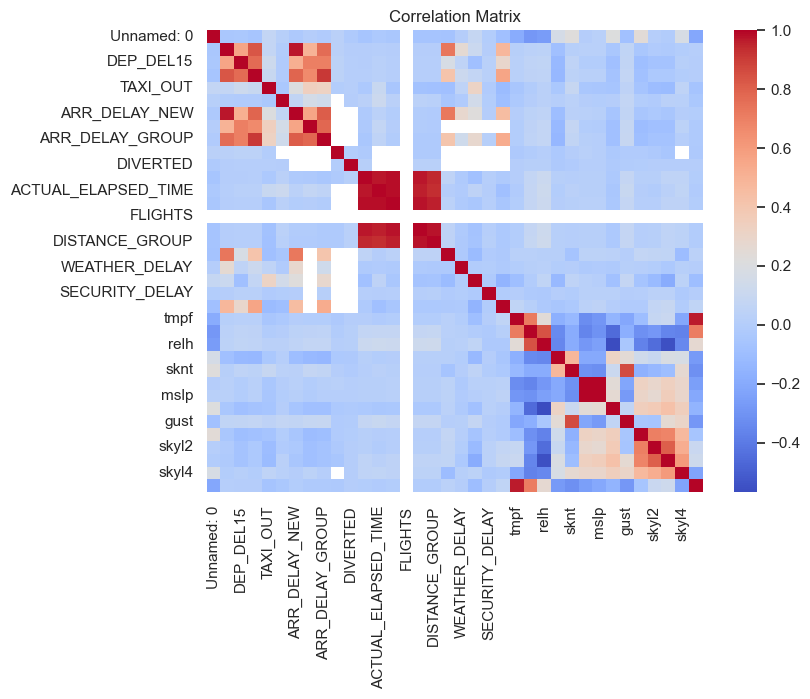

Highly Correlated Feature Pairs:
('DEP_DELAY_NEW', 'DEP_DELAY_GROUP')
('DEP_DELAY_NEW', 'ARR_DELAY_NEW')
('DEP_DELAY_NEW', 'ARR_DELAY_GROUP')
('DEP_DELAY_NEW', 'CARRIER_DELAY')
('DEP_DEL15', 'DEP_DELAY_GROUP')
('DEP_DEL15', 'ARR_DEL15')
('DEP_DELAY_GROUP', 'ARR_DELAY_NEW')
('DEP_DELAY_GROUP', 'ARR_DELAY_GROUP')
('ARR_DELAY_NEW', 'ARR_DELAY_GROUP')
('ARR_DELAY_NEW', 'CARRIER_DELAY')
('ARR_DEL15', 'ARR_DELAY_GROUP')
('CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME')
('CRS_ELAPSED_TIME', 'AIR_TIME')
('CRS_ELAPSED_TIME', 'DISTANCE')
('CRS_ELAPSED_TIME', 'DISTANCE_GROUP')
('ACTUAL_ELAPSED_TIME', 'AIR_TIME')
('ACTUAL_ELAPSED_TIME', 'DISTANCE')
('ACTUAL_ELAPSED_TIME', 'DISTANCE_GROUP')
('AIR_TIME', 'DISTANCE')
('AIR_TIME', 'DISTANCE_GROUP')
('DISTANCE', 'DISTANCE_GROUP')
('tmpf', 'dwpf')
('tmpf', 'feel')
('dwpf', 'relh')
('dwpf', 'feel')
('sknt', 'gust')
('alti', 'mslp')
('skyl1', 'skyl2')
('skyl2', 'skyl3')


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_data = df[numeric_columns]
correlation_matrix = numeric_data.corr()

# seaborn heatmapa
sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

highly_correlated = np.where(np.abs(correlation_matrix) > 0.7)
# feature pairs
correlated_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                    for i, j in zip(*highly_correlated) if i != j and i < j]
print("Highly Correlated Feature Pairs:")
for pair in correlated_pairs:
    print(pair)


## Korelace arrival a departure delay ve scatter plot

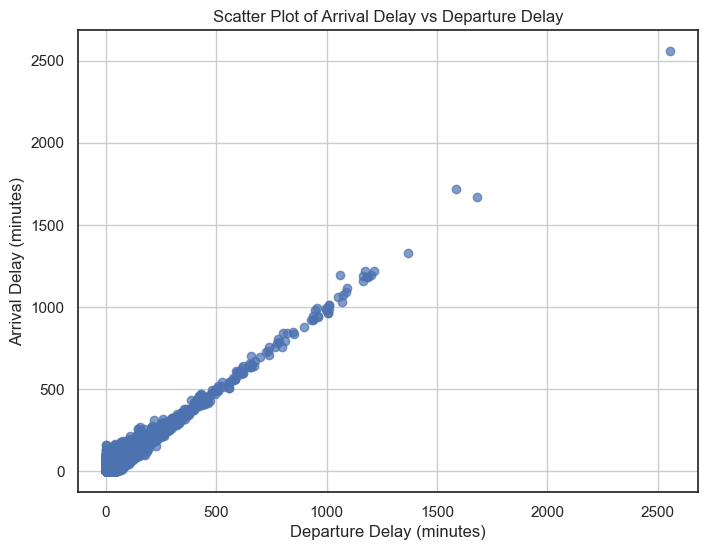

In [94]:
plt.figure(figsize=(8, 6))
plt.scatter(df['DEP_DELAY_NEW'], df['ARR_DELAY_NEW'], alpha=0.7)
plt.title('Scatter Plot of Arrival Delay vs Departure Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True)
plt.show()

## Vizualizace arrival a departure delay v závislosti na délce letu

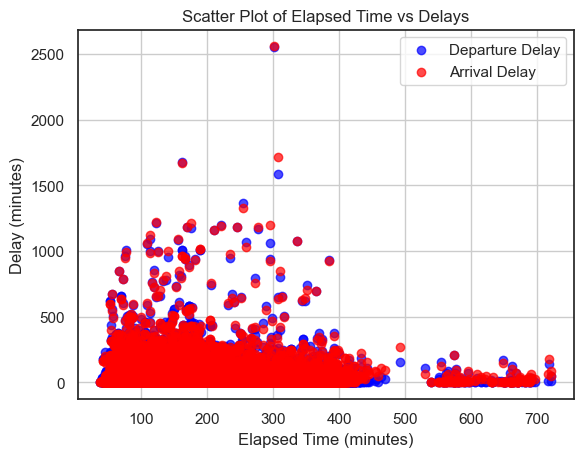

In [95]:
scatter = plt.scatter(df['ACTUAL_ELAPSED_TIME'], df['DEP_DELAY_NEW'], c='blue', label='Departure Delay', alpha=0.7)
plt.scatter(df['ACTUAL_ELAPSED_TIME'], df['ARR_DELAY_NEW'], c='red', label='Arrival Delay', alpha=0.7)
plt.legend()
plt.title('Scatter Plot of Elapsed Time vs Delays')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Delay (minutes)')
plt.grid(True)
plt.show()

## Vizualizace jednotlivých typů a délky zpoždění 
Nejedná se o kompletní data ale o subset 5000 letů, kvůli lepší přehlednosti grafu

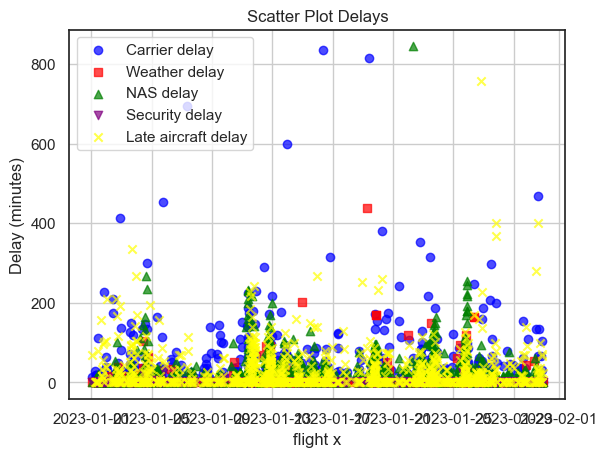

In [96]:
subset_size = 5000
df_subset = df.sample(n=subset_size, random_state=1784167)

scatter_carrier = plt.scatter(df_subset['valid_date_time_H'], df_subset['CARRIER_DELAY'], c='blue', label='Carrier delay', alpha=0.7, marker='o')
scatter_weather = plt.scatter(df_subset['valid_date_time_H'], df_subset['WEATHER_DELAY'], c='red', label='Weather delay', alpha=0.7, marker='s')
scatter_nas = plt.scatter(df_subset['valid_date_time_H'], df_subset['NAS_DELAY'], c='green', label='NAS delay', alpha=0.7, marker='^')
scatter_sec = plt.scatter(df_subset['valid_date_time_H'], df_subset['SECURITY_DELAY'], c='purple', label='Security delay', alpha=0.7, marker='v')
scatter_lateac = plt.scatter(df_subset['valid_date_time_H'], df_subset['LATE_AIRCRAFT_DELAY'], c='yellow', label='Late aircraft delay', alpha=0.7, marker='x')

plt.legend()
plt.title('Scatter Plot Delays')
plt.xlabel('flight x')
plt.ylabel('Delay (minutes)')
plt.grid(True)
plt.show()

## Detailnější pohled na zpoždění způsobené počasím

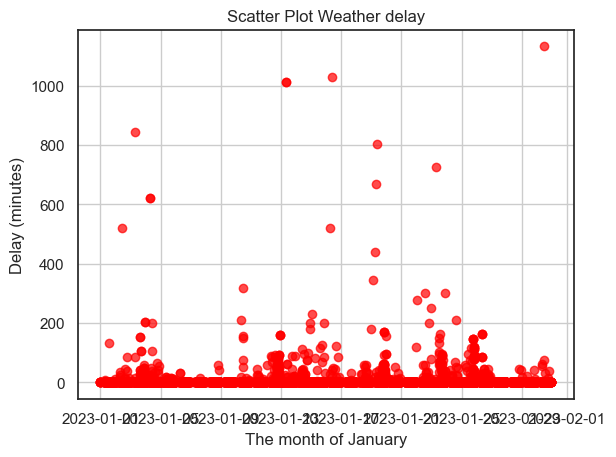

In [97]:
scatter_weather = plt.scatter(df['valid_date_time_H'], df['WEATHER_DELAY'], c='red', label='Weather delay', alpha=0.7, marker='o')
plt.title('Scatter Plot Weather delay')
plt.xlabel('The month of January')
plt.ylabel('Delay (minutes)')
plt.grid(True)
plt.show()

## Poslední vizualizace zpoždění zaviněného počasím a rychlostí větru a jeho typu gust/wind

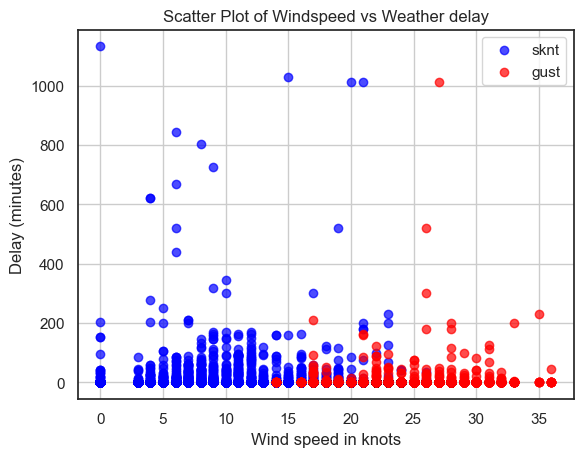

In [98]:
scatter = plt.scatter(df['sknt'], df['WEATHER_DELAY'], c='blue', label='sknt', alpha=0.7)
plt.scatter(df['gust'], df['WEATHER_DELAY'], c='red', label='gust', alpha=0.7)
plt.legend()
plt.title('Scatter Plot of Windspeed vs Weather delay')
plt.xlabel('Wind speed in knots')
plt.ylabel('Delay (minutes)')
plt.grid(True)
plt.show()

# Kategorizace atributů 

### Kategorizace teploty a vlhkosti vzduchu

In [99]:
def label_encode(df, columns):
    labels = ['Very low', 'Low', 'Average', 'High', 'Very high']

    for column in columns:
        # podle kvantilů
        df[column + '_category'] = pd.qcut(df[column], q=5, labels=labels)
    return df
df = label_encode(df, ['tmpf', 'relh','dwpf'])

### Kategorizace směru větru

In [100]:
def categorize_wind_direction(df, column):
    boundaries = [0, 90, 180, 270, 360]
    labels = ['North-East', 'South-East', 'South-West', 'North-West']
    df[column + '_category'] = pd.cut(df[column], bins=boundaries, labels=labels, include_lowest=True)
    return df
df = categorize_wind_direction(df, 'drct')

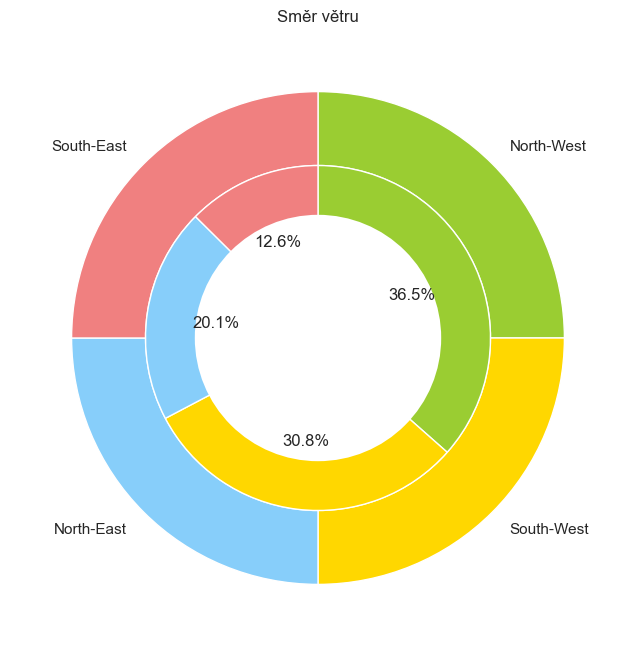

In [101]:
def plot_wind_direction(df, column):
    frequencies = df[column].value_counts()
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    plt.figure(figsize=(8, 8))
    plt.pie([1, 1, 1, 1], labels=frequencies.index, colors=colors, 
            startangle=90, counterclock=False, wedgeprops=dict(width=0.3))
    plt.pie(frequencies, labels=None, radius=0.7, colors=colors, 
            startangle=90, counterclock=False, autopct='%1.1f%%')
    centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('Směr větru')
    plt.show()

plot_wind_direction(df, 'drct_category')


### kategorizace wind speed in knots (sknt), 
### + 2 kategorie extreme low a extreme high = lowest a highest decile 

In [102]:
def label_encode(df, columns):
    labels = ['Extreme Low', 'Very Low', 'Low', 'Average', 'High', 'Very High', 'Extreme High']
    for column in columns:
        df[column + '_category'] = pd.qcut(df[column], q=[0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1], labels=labels)
    return df
df = label_encode(df, ['sknt'])

### kategorizace CARRIER_DELAY	WEATHER_DELAY	NAS_DELAY	SECURITY_DELAY

In [103]:
def categorize_delay(df, columns):
    boundaries = [0, 5, 15, 30, 60, 120, 180, np.inf]
    labels = ['Low', 'Noticeable', 'Medium', 'Above Average', 'High', 'Very High', 'Extreme']
    for column in columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            df[column].fillna(0, inplace=True)  # missing hodnoty
            df[column + '_category'] = pd.cut(df[column], bins=boundaries, labels=labels, include_lowest=True)
        else:
            print(f"Cannot categorize column '{column}' because it's not numeric.")

    return df
columns_to_categorize = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
df = categorize_delay(df, columns_to_categorize)



### Vytvoření kategorie denní hodiny
jenom další sloupec, který ale obsahuje pouze hodinu ve které se let uskutečnil

In [104]:
df['time'] = df['valid_date_time_H'].dt.strftime('%H:%M')


# 3 volitelné metody
Síťový graf - vizualizační balíček,
K-means clustering,
Predikce - Decision Tree classifier,
Tyto 3 úlohy jsou umístěny zde, protože CleverMiner nám některé attributy v dataframu ignoroval. 

### Síťový graf letišť a letů mezi nimi
V prezentaci je vizuálně lepší kvůli upravené velikosti 

In [105]:
import plotly.graph_objects as go
import networkx as nx

# inicializace grafu
G = nx.Graph()
for index, row in df.iterrows():
    G.add_edge(row['ORIGIN'], row['DEST'], weight=row['DISTANCE'])
pos = nx.spring_layout(G)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

fig = go.Figure()

# hrany
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(color='rgba(80,80,80,0.5)')))

# uzly
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', text=list(G.nodes()), marker=dict(size=[np.log(v+1) * 20 for v in dict(G.degree).values()], color='rgba(222,45,38,0.8)'), hoverinfo='text'))

# anotace
for node in G.nodes():
    fig.add_annotation(
        x=pos[node][0], 
        y=pos[node][1],
        text=node,
        showarrow=False,
        font=dict(size=12)
    )

fig.update_layout(showlegend=False, autosize=False,) # neodpovídá prezentaci kvůli úpravě pro větší rozlišení
fig.show()


### K-means clustering letišť podle počtu a délky letů

c:\Users\lukas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\lukas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



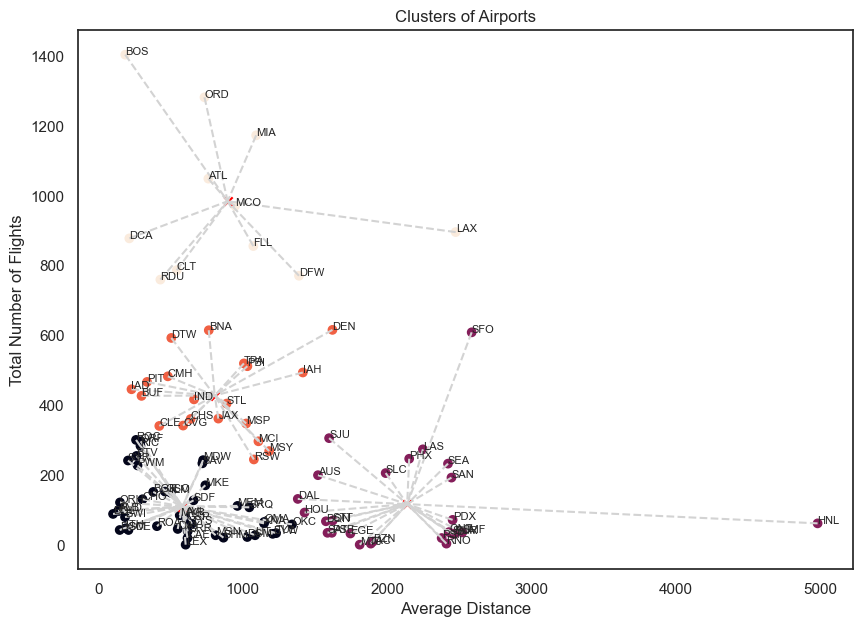

In [106]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# LGA a JFK letiště jsou extrémní outliers proto odebíráme
df = df[(df['ORIGIN'] != 'LGA') & (df['ORIGIN'] != 'JFK')]

# groupby letiště
airport_data = df.groupby('ORIGIN').agg({
    'DISTANCE': 'mean',
    'FLIGHTS': 'sum'
})

# Imputing missing pro jistotu
imputer = SimpleImputer(strategy='mean')
airport_data_imputed = imputer.fit_transform(airport_data)

scaler = StandardScaler().fit(airport_data_imputed)
airport_data_scaled = scaler.transform(airport_data_imputed)

# KMeans
model = KMeans(n_clusters=4)
model.fit(airport_data_scaled)
labels = model.labels_
airport_data['cluster'] = labels

plt.figure(figsize=(10, 7))
plt.scatter(airport_data['DISTANCE'], airport_data['FLIGHTS'], c=airport_data['cluster'])
plt.xlabel('Average Distance')
plt.ylabel('Total Number of Flights')
plt.title('Clusters of Airports')

# jména letišť
for i, airport in enumerate(airport_data.index):
    plt.text(airport_data['DISTANCE'].iloc[i], airport_data['FLIGHTS'].iloc[i], airport, fontsize=8)  # Adjust fontsize as needed

# centroidy
centroids = model.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids)
plt.scatter(centroids_original_scale[:, 0], centroids_original_scale[:, 1], c='red', marker='x')

# spojení s cetroidy
for i in range(len(airport_data)):
    plt.plot([airport_data['DISTANCE'].iloc[i], centroids_original_scale[labels[i], 0]], 
             [airport_data['FLIGHTS'].iloc[i], centroids_original_scale[labels[i], 1]], 
             c='lightgray', linestyle='--')
plt.show()



# Predikce target variable DEP_DELAY_GROUP 

In [107]:
# PREDIKCE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

parameters = ['ARR_DELAY_GROUP', 'CARRIER_DELAY_category', 'WEATHER_DELAY_category', 'NAS_DELAY_category',
            'SECURITY_DELAY_category', 'LATE_AIRCRAFT_DELAY_category', 'dwpf_category', 'sknt_category',
            'drct_category', 'tmpf_category', 'relh_category']

# Target
target = 'DEP_DELAY_GROUP'

# Odstranění prázdných hodnot z DEP_DELAY_GROUP
df_copy = df.copy()
df_copy2 = df_copy[df_copy.DEP_DELAY_GROUP.notnull()]

# Načtení parametrů a targetu
x = df_copy2[parameters]
y = df_copy2[target]

# Převod sloupců na numerické hodnoty
label_encoder = LabelEncoder()
x_encoded = x.apply(label_encoder.fit_transform)

# Rozdělení dat na trénovací a testovací
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.1, random_state=40)

# Trénovaní klasifikátoru
model = DecisionTreeClassifier(random_state=40)
model.fit(x_train, y_train)

# Predikce na testovacích datech
y_pred = model.predict(x_test)

# Zhodnocení
dt_accuracy = accuracy_score(y_test, y_pred)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.6763


# Řešení analytických otázek

In [108]:
from cleverminer import cleverminer as cm

Příprava dataframu s nenulovou hodnotou DEP_DELAY pro využití v úloze CF_MINER_3

In [109]:
df_not_null = df[df['DEP_DELAY_NEW'] != 0.0]

## CF_MINER_1

In [110]:
clm = cm(df=df,target='DISTANCE_GROUP',proc='CFMiner',
               quantifiers= {'RelBase':0.001},
               cond ={
                    'attributes':[
                        {'name': 'DEP_DELAY_GROUP', 'type': 'seq', 'minlen': 1, 'maxlen': 3},
                        {'name': 'ARR_DELAY_GROUP', 'type': 'seq', 'minlen': 1, 'maxlen': 3},
                    ], 'minlen':1, 'maxlen':2, 'type':'con'},
                opts = {'max_categories': 500}
               )
clm.print_rule(809)

Cleverminer version 1.0.8.
Starting data preparation ...
Automatically reordering numeric categories ...
 If you haven't set maximum number of categories and you really need more categories and you know what you are doing, please use max_categories option to increase allowed number of categories.
 If you haven't set maximum number of categories and you really need more categories and you know what you are doing, please use max_categories option to increase allowed number of categories.
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
  0%|                                                    |Elapsed Time: 0:00:00
 11%|######                                              |Elapsed Time: 0:00:00
 21%|###########                                         |Elapsed Time: 0:00:00
 32%|#################                                   |Elapsed Time: 0:00:00
100%|########################################

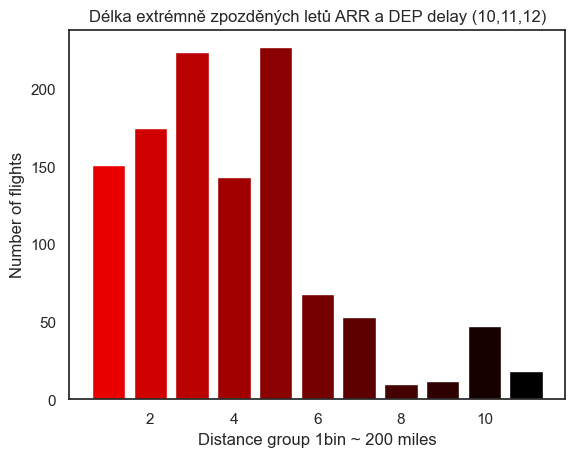

In [111]:
import matplotlib.colors as mcolors

labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
histogram = [151, 175, 224, 143, 227, 68, 53, 10, 12, 47, 18]

# barva
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "black"])
plt.bar(labels, histogram, color=cmap(np.array(labels)/max(labels)))
plt.xlabel('Distance group 1bin ~ 200 miles')
plt.ylabel('Number of flights')
plt.title('Délka extrémně zpozděných letů ARR a DEP delay (10,11,12)')
plt.show()

# CF_MINER_2

In [112]:
clm = cm(df=df,target='ARR_DELAY_GROUP',proc='CFMiner',
               quantifiers= {'Base': 50},
               cond ={
                   'attributes':[
                        {'name': 'CARRIER_DELAY_category', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'WEATHER_DELAY_category', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'NAS_DELAY_category', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'SECURITY_DELAY_category', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'LATE_AIRCRAFT_DELAY_category', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        ], 'minlen':5, 'maxlen':5, 'type':'con'},
                opts = {'max_categories': 500}
               )
clm.print_rule(25)

Cleverminer version 1.0.8.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
  0%|                                                    |Elapsed Time: 0:00:00
 10%|#####                                               |Elapsed Time: 0:00:00
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 27, rules 27, times: prep 2.27sec, processing 0.10sec


Rule id : 25

Base :   171  Relative base : 0.006  Steps UP (consecutive) :     1  Steps DOWN (consecutive) :     5  Steps UP (any) :     1  Steps DOWN (any) :     5  Histogram maximum :    66  Histogram minimum :     0  Histogram relative maximum : 0.386 Histogram relative minimum : 0.000 

Condition  : CARRIER_DELAY_category(High) & WEATHER_DELAY_category(Low) & NAS_DELAY_category(Low) & SECURITY_DELAY_category(Low) & LAT

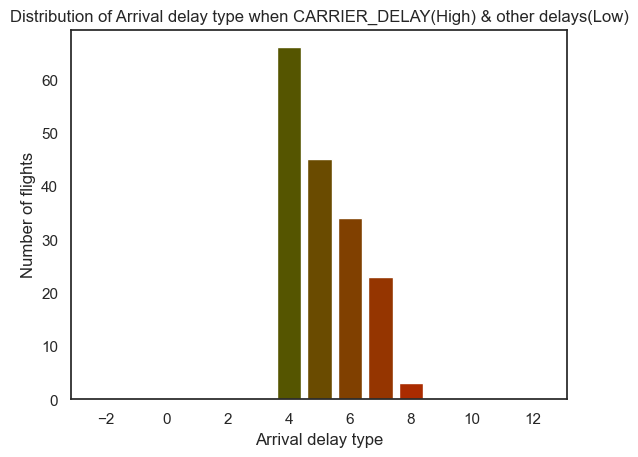

In [113]:
import matplotlib.colors as mcolors

labels = [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
histogram = [0, 0, 0, 0, 0, 0, 66, 45, 34, 23, 3, 0, 0, 0, 0]

# barva
cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "red"])

plt.bar(labels, histogram, color=cmap(np.array(labels)/max(labels)))
plt.xlabel('Arrival delay type')
plt.ylabel('Number of flights')
plt.title('Distribution of Arrival delay type when CARRIER_DELAY(High) & other delays(Low)')
plt.show()

# CF_MINER_3

In [114]:
clm = cm(df= df_not_null,target='DEP_DELAY_GROUP',proc='CFMiner',
               quantifiers= {'Base':30, 'S_Any_Up':3},
               cond ={
                   'attributes':[
                        {'name': 'vsby', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'station', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'drct_category', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'sknt_category', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        ], 'minlen':4, 'maxlen':4, 'type':'con'},
                opts = {'max_categories': 500}
               )
clm.print_rule(1)

Cleverminer version 1.0.8.
Starting data preparation ...
Automatically reordering numeric categories ...


c:\Users\lukas\anaconda3\Lib\site-packages\cleverminer\cleverminer.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\lukas\anaconda3\Lib\site-packages\cleverminer\cleverminer.py:183: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\lukas\anaconda3\Lib\site-packages\cleverminer\cleverminer.py:188: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

 If you haven't set maximum number of categories and you really need more categories and you know what you are doing, please use max_categories option to increase allowed number of categories.
 If you haven't set maximum number of categories and you really need more categories and you know what you are doing, please use max_categories option to increase allowed number of categories.
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
  0%|                                                    |Elapsed Time: 0:00:00
 17%|#########                                           |Elapsed Time: 0:00:00
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 72, rules 4, times: prep 1.35sec, processing 0.09sec


Rule id : 1

Base :   261  Relative base : 0.027  Steps UP (consecutive) :     3  Steps DOWN (consecutive) :     4  Steps UP (any) :     5  Steps D

### bohužel se něco někde pohnulo a nemůžu reprodukovat výsledky uvedené v grafu. CFMiner už uvedené pravidlo nenajde

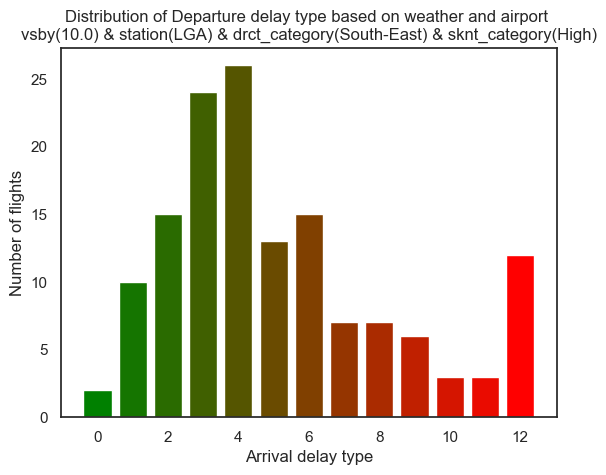

In [115]:
import matplotlib.colors as mcolors

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
histogram = [2, 10, 15, 24, 26, 13, 15, 7, 7, 6, 3, 3, 12]

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "red"])

plt.bar(labels, histogram, color=cmap(np.array(labels)/max(labels)))
plt.xlabel('Arrival delay type')
plt.ylabel('Number of flights')
plt.title('Distribution of Departure delay type based on weather and airport \nvsby(10.0) & station(LGA) & drct_category(South-East) & sknt_category(High)')
plt.show()

# 4ftMiner

# SD-4FT_MINER_2

In [116]:
clm = cm(df=df,proc='SD4ftMiner',
               quantifiers= {'Base1':20, 'Base2':20, 'Ratioconf' : 1.8},
               ante ={
                    'attributes':[
                        {'name': 'skyc1', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'DEP_DELAY_GROUP', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'DEST', 'type': 'one', 'value':'LGA'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'DEST', 'type': 'one', 'value':'JFK'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               opts = {'max_categories' : 500}
               )

clm.print_rulelist()
clm.print_rule(1)

Cleverminer version 1.0.8.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
  0%|                                                    |Elapsed Time: 0:00:00
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 58, rules 5, times: prep 2.09sec, processing 0.04sec

List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1   197    73    1.957    +0.021  skyc1(BKN) => DEP_DELAY_GROUP(3) | --- : DEST(LGA) x DEST(JFK)
     2   154    54    2.069    +0.018  skyc1(BKN) => DEP_DELAY_GROUP(4) | --- : DEST(LGA) x DEST(JFK)
     3    79    22    2.605    +0.011  skyc1(BKN) => DEP_DELAY_GROUP(6) | --- : DEST(LGA) x DEST(JFK)
     4    74    20    2.684    +0.010  skyc1(BKN) => DEP_DELAY_GROUP(7) | --- : DEST(LGA) x DEST(JFK)
     5    57    23    1.875    +0.009  

# SD-4FT_MINER_3

In [117]:
clm = cm(df=df,proc='SD4ftMiner',
               quantifiers= {'Base1':20, 'Base2':20, 'Ratioconf' : 2},
               ante ={
                    'attributes':[
                        {'name': 'wxcodes', 'type': 'subset', 'minlen': 1, 'maxlen': 2}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'DEP_DELAY_GROUP', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'DEST', 'type': 'one', 'value':'LGA'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'DEST', 'type': 'one', 'value':'JFK'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               opts = {'max_categories' : 500}
               )

clm.print_rulelist()
clm.print_rule(1)

Cleverminer version 1.0.8.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
  0%|                                                    |Elapsed Time: 0:00:00
  2%|#                                                   |Elapsed Time: 0:00:00
  5%|##                                                  |Elapsed Time: 0:00:00
  8%|####                                                |Elapsed Time: 0:00:00
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 1026, rules 40, times: prep 2.27sec, processing 0.22sec

List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1   115    35    2.234    +0.052  wxcodes(+RA -RA) => DEP_DELAY_GROUP(2) | --- : DEST(LGA) x DEST(JFK)
     2    79    21    2.558    +0.039  wxcodes(+RA -RA) => DEP_DELAY_GROUP(3) | --- : DEST(LGA) 